# Player Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")


%matplotlib inline

## Data Cleaning and Exploration

In [2]:
df1 = pd.read_csv("matches.csv")
df2 = pd.read_csv("deliveries.csv")

df1.rename(columns={"id" : 'match_id'}, inplace=True)

matches= pd.merge(df1, df2, on='match_id', how='outer')

In [3]:
matches.columns

Index(['match_id', 'season', 'city', 'date', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'result', 'dl_applied', 'winner', 'win_by_runs',
       'win_by_wickets', 'player_of_match', 'venue', 'umpire1', 'umpire2',
       'umpire3', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

In [4]:
matches = matches[['match_id', 'season','team1', 'team2', 'toss_winner','toss_decision','dl_applied','winner',
       'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman','non_striker', 'bowler','wide_runs','bye_runs', 'legbye_runs','noball_runs','penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind']]

matches.shape

(179078, 26)

## Taking in conisderation SRH VS MI matches

In [5]:
SRH_MI = matches[np.logical_or(np.logical_and(matches['team1']=='Sunrisers Hyderabad',matches['team2']=='Mumbai Indians'),
                            np.logical_and(matches['team2']=='Sunrisers Hyderabad',matches['team1']=='Mumbai Indians'))]

In [7]:
SRH_MI.match_id.nunique()

14

In [8]:
SRH_MI.season.unique()

array([2017, 2013, 2014, 2015, 2016, 2018, 2019], dtype=int64)

## Stamina Score

In [539]:
def stamina_score (player_name,opposition_team):
    
    #batsman runs
    player = matches[(matches["bowling_team"]==opposition_team)&(matches["batsman"]==player_name)]

    player_runs= player[player["wide_runs"]==0]

    batsman_runs = player_runs.groupby(["match_id"]).agg({"batsman_runs":"sum","ball":"count"})
    
    batsman_runs.columns = ["batsman_runs","total balls"]

    
    #player on crease
    crease = matches[(matches["batsman"]==player_name)|(matches["non_striker"]==player_name)]
    
    crease = crease[(crease["wide_runs"]==0)&(crease["noball_runs"]==0)]
    
    player_on_crease = pd.DataFrame(crease.groupby(["match_id"])["ball"].count())

    player_on_crease.columns = ["player_on_crease"]
    
    
    #boundaries runs
    player_boundaries = player_runs[(player_runs["batsman_runs"]==4)|(player_runs["batsman_runs"]==6)]

    boundary_runs = pd.DataFrame(player_boundaries.groupby(["match_id"])["batsman_runs"].sum())

    boundary_runs.columns = ["boundary runs"]
    
    #runs by 1,2 and 3
    player_running = player_runs[(player_runs["batsman_runs"]==1)|(player_runs["batsman_runs"]==2)|(player_runs["batsman_runs"]==3)]

    batsman_running = pd.DataFrame(player_running.groupby(["match_id"])["batsman_runs"].sum())

    batsman_running.columns = ["running runs"]
    
    
    #merging the data
    final = pd.merge(batsman_runs,player_on_crease,on="match_id",how ="inner")
    final = pd.merge(final,boundary_runs,on="match_id",how ="outer") 
    final = pd.merge(final,batsman_running,on="match_id",how ="outer")

    final["boundary runs"].fillna(0, inplace = True)
    final["running runs"].fillna(0, inplace = True)
    final["batsman_runs"].fillna(0, inplace = True)

    final = final[final["batsman_runs"]>15]
    
    final["Stamina Score"] = ((final["running runs"]/(final["boundary runs"]+1))+(final["total balls"]/final["player_on_crease"])) / final["batsman_runs"]
    
    
    stamina_player = sum(final['Stamina Score'])/len(final['Stamina Score'])
    return stamina_player

- Batsman

In [600]:
warner = round(stamina_score("DA Warner","Mumbai Indians"),2)

quinton = round(stamina_score("Q de Kock","Sunrisers Hyderabad"),2)

williamson = round(stamina_score("KS Williamson","Mumbai Indians"),2)

ishan = round(stamina_score("Ishan Kishan","Sunrisers Hyderabad"),2)

pollard = round(stamina_score("KA Pollard","Sunrisers Hyderabad"),2)

manish = round(stamina_score("MK Pandey","Mumbai Indians"),2)

saha = round(stamina_score("WP Saha","Mumbai Indians"),2)

surya = round(stamina_score("SA Yadav","Sunrisers Hyderabad"),2)

hardik = round(stamina_score("HH Pandya","Sunrisers Hyderabad"),2)

bairstow = round(stamina_score("J Bairstow","Mumbai Indians"),2)

rohit = round(stamina_score("RG Sharma","Sunrisers Hyderabad"),2)

In [601]:
batsman = [warner,quinton,williamson,ishan,pollard,manish,saha,surya,hardik,bairstow,rohit]

SS_batsman = pd.DataFrame(batsman)

SS_batsman.columns = ["Stamina Score"]

SS_batsman

,Stamina Score
0,0.04
1,0.03
2,0.03
3,0.05
4,0.02
5,0.13
6,0.03
7,0.07
8,0.04
9,0.05


### Final SS

- Warner

In [602]:
final_warner = (warner - min(SS_batsman["Stamina Score"])) / (max(SS_batsman["Stamina Score"]) - min(SS_batsman["Stamina Score"]))
print("SS for Warner:",round(final_warner,2))

SS for Warner: 0.18


- Quinton de Kock

In [603]:
final_quinton = (quinton - min(SS_batsman["Stamina Score"])) / (max(SS_batsman["Stamina Score"]) - min(SS_batsman["Stamina Score"]))
print("SS for QDK:",round(final_quinton,2))

SS for QDK: 0.09


- Williamson

In [604]:
final_kane = (williamson - min(SS_batsman["Stamina Score"])) / (max(SS_batsman["Stamina Score"]) - min(SS_batsman["Stamina Score"]))
print("SS for Williamson:",round(final_kane,2))

SS for Williamson: 0.09


- Ishan Kishan

In [605]:
final_kishan = (ishan - min(SS_batsman["Stamina Score"])) / (max(SS_batsman["Stamina Score"]) - min(SS_batsman["Stamina Score"]))
print("SS for Ishan :",round(final_kishan,2))

SS for Ishan : 0.27


- Pollard 

In [606]:
final_pollard = (pollard - min(SS_batsman["Stamina Score"])) / (max(SS_batsman["Stamina Score"]) - min(SS_batsman["Stamina Score"]))
print("SS for Pollard:",round(final_pollard,2))

SS for Pollard: 0.0


- Manish Pandey

In [607]:
final_manish = (manish - min(SS_batsman["Stamina Score"])) / (max(SS_batsman["Stamina Score"]) - min(SS_batsman["Stamina Score"]))
print("SS for Manish:",round(final_manish,2))

SS for Manish: 1.0


- Saha

In [608]:
final_saha = (saha - min(SS_batsman["Stamina Score"])) / (max(SS_batsman["Stamina Score"]) - min(SS_batsman["Stamina Score"]))
print("SS for Saha:",round(final_saha,2))

SS for Saha: 0.09


- S Yadav

In [609]:
final_surya = (surya - min(SS_batsman["Stamina Score"])) / (max(SS_batsman["Stamina Score"]) - min(SS_batsman["Stamina Score"]))
print("SS for S Yadav:",round(final_surya,2))

SS for S Yadav: 0.45


- Hardik Pandya

In [610]:
final_hardik = (hardik - min(SS_batsman["Stamina Score"])) / (max(SS_batsman["Stamina Score"]) - min(SS_batsman["Stamina Score"]))
print("SS for Hardik:",round(final_hardik,2))

SS for Hardik: 0.18


- Bairstow

In [611]:
final_bairstow = (bairstow - min(SS_batsman["Stamina Score"])) / (max(SS_batsman["Stamina Score"]) - min(SS_batsman["Stamina Score"]))
print("SS for Bairstow:",round(final_bairstow,2))

SS for Bairstow: 0.27


- Rohit Sharma

In [612]:
final_rohit = (rohit - min(SS_batsman["Stamina Score"])) / (max(SS_batsman["Stamina Score"]) - min(SS_batsman["Stamina Score"]))
print("SS for Rohit:",round(final_rohit,2))

SS for Rohit: 0.27


So from all the above Stamina score that we have calculated for varius players, we can predict that Surya Kumar Yadav and Manish Pandey can have higher stamina score 

## Smash rate

In [129]:
def smash_rate(player_name, opposition_team):
    
    #batsman runs and balls faced
    player = matches[(matches["bowling_team"]==opposition_team)&(matches["batsman"]==player_name)]

    player = player[player["wide_runs"]==0]

    batsman_runs = player.groupby(["match_id"]).agg({"batsman_runs":"sum","ball":"count"})
    
    #batsman boundaries count
    player_boundaries = player[(player["batsman_runs"]==4)|(player["batsman_runs"]==6)]

    boundary_runs = pd.DataFrame(player_boundaries.groupby(["match_id"])["batsman_runs"].count())

    boundary_runs.columns = ["boundary count"]
    
    #merging the data together
    final = pd.merge(batsman_runs,boundary_runs, on = "match_id", how = "outer")
    
    final["boundary count"].fillna(0, inplace = True)
    
    final["batsman_runs"].fillna(0, inplace = True)
    
    #smash rate
    final["smash_rate"] = (final["boundary count"]/final ["ball"])*100
    print(final)
    print(" ")
    
    #visualization
    plt.figure(figsize = (25,18))
    plt.subplot(3,3,1)
    sns.kdeplot(final["smash_rate"])
    plt.subplot(3,3,2)
    sns.boxplot(final["smash_rate"])

    smash_player = sum(final["smash_rate"])/len(final["smash_rate"])
    print("Average Smash Rate :",round(smash_player,2))

- Ishan Kishan

          batsman_runs  ball  boundary count  smash_rate
match_id                                                
52                  61    40             9.0   22.500000
7900                13     9             3.0   33.333333
7916                 0     3             0.0    0.000000
11310               17    21             2.0    9.523810
 
Average Smash Rate : 16.34


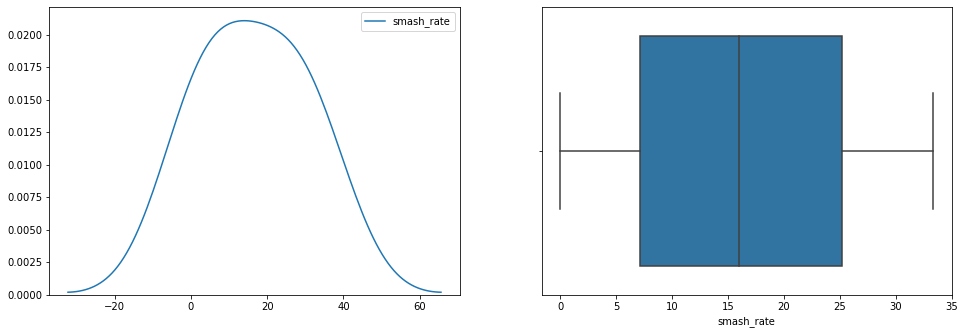

In [130]:
smash_rate("Ishan Kishan","Sunrisers Hyderabad")

- David Warner

          batsman_runs  ball  boundary count  smash_rate
match_id                                                
10                  49    34             9.0   26.470588
47                   6     6             1.0   16.666667
150                 21    30             1.0    3.333333
170                 15     9             2.0   22.222222
221                 31    15             6.0   40.000000
238                  1     3             0.0    0.000000
282                  1     2             0.0    0.000000
390                 61    37             9.0   24.324324
408                  7     5             1.0   20.000000
477                 65    51             5.0    9.803922
493                 55    31             8.0   25.806452
541                  9     7             2.0   28.571429
572                  6     5             1.0   20.000000
588                 90    59            11.0   18.644068
613                 48    33             8.0   24.242424
11310               16    13   

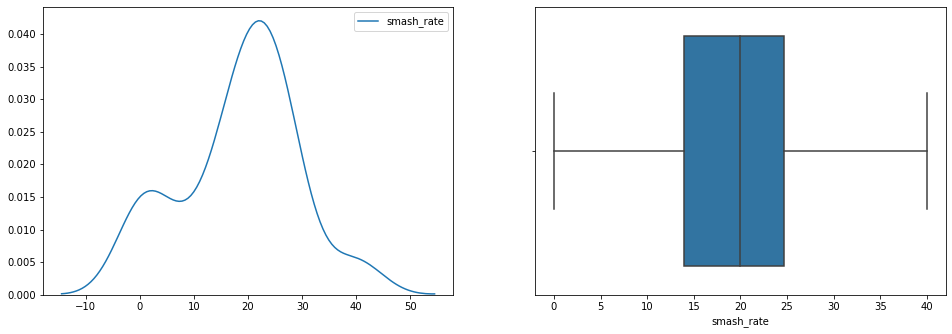

In [131]:
smash_rate("DA Warner","Mumbai Indians")

- Pollard

          batsman_runs  ball  boundary count  smash_rate
match_id                                                
10                  11    11             1.0    9.090909
47                   5     9             0.0    0.000000
423                 14    19             1.0    5.263158
444                 66    27            10.0   37.037037
477                 78    48             9.0   18.750000
493                  6     7             0.0    0.000000
541                 33    24             4.0   16.666667
613                 11    13             2.0   15.384615
7900                28    23             5.0   21.739130
7916                 9     6             1.0   16.666667
11310               47    26             6.0   23.076923
11342               12    10             1.0   10.000000
 
Average Smash Rate : 14.47


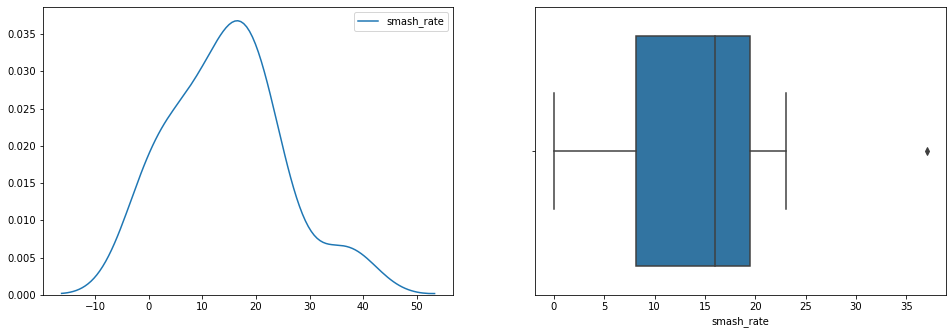

In [132]:
smash_rate("KA Pollard","Sunrisers Hyderabad")

- Manish Pandey

          batsman_runs  ball  boundary count  smash_rate
match_id                                                
7                   81    47            10.0   21.276596
53                  33    33             2.0    6.060606
188                 40    27             5.0   18.518519
226                 16    18             2.0   11.111111
231                  5     9             0.0    0.000000
277                 59    47             7.0   14.893617
310                  0     5             0.0    0.000000
439                 29    29             2.0    6.896552
458                 64    53             8.0   15.094340
497                 14    21             0.0    0.000000
518                 40    24             5.0   20.833333
567                  1     1             0.0    0.000000
581                 52    29             6.0   20.689655
7900                11     8             1.0   12.500000
7916                16    11             3.0   27.272727
11310               16    21   

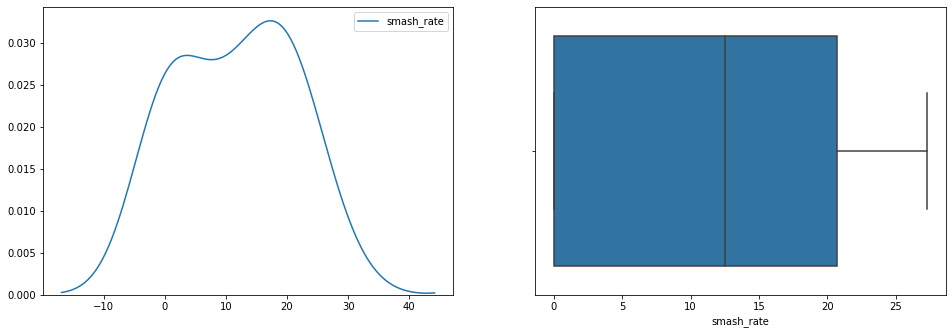

In [133]:
smash_rate('MK Pandey',"Mumbai Indians")

- Quinton de Kock

          batsman_runs  ball  boundary count  smash_rate
match_id                                                
469                 48    30             7.0   23.333333
489                  7    12             0.0    0.000000
561                 50    31            10.0   32.258065
618                 44    31             7.0   22.580645
628                  2     9             0.0    0.000000
11310               19    18             2.0   11.111111
11342               75    58             8.0   13.793103
 
Average Smash Rate : 14.73


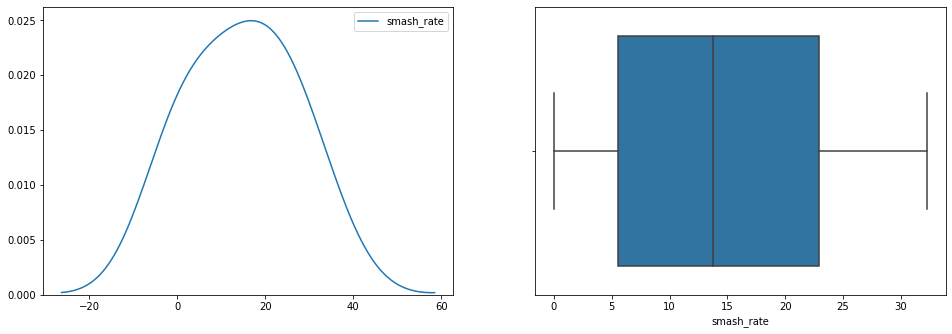

In [552]:
smash_rate('Q de Kock',"Sunrisers Hyderabad")

- Hardik Pandya

          batsman_runs  ball  boundary count  smash_rate
match_id                                                
10                   2     3             0.0    0.000000
47                  15    24             0.0    0.000000
588                  2     5             0.0    0.000000
613                  7    16             0.0    0.000000
7916                 4    19             0.0    0.000000
11310               14    14             1.0    7.142857
11342               25    12             3.0   25.000000
 
Average Smash Rate : 4.59


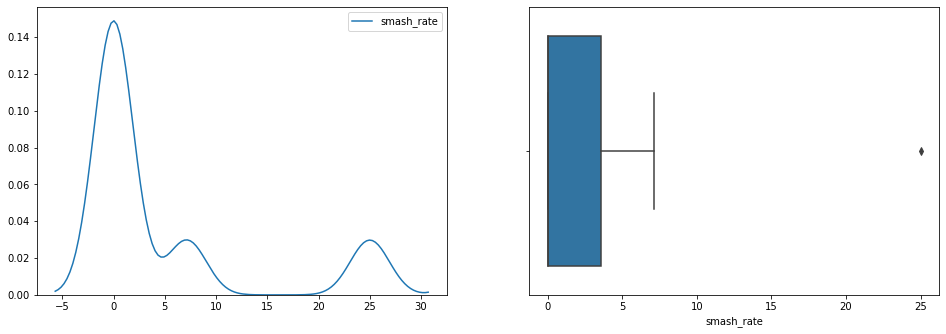

In [554]:
smash_rate("HH Pandya","Sunrisers Hyderabad")

- Surya Kumar Yadav

          batsman_runs  ball  boundary count  smash_rate
match_id                                                
14                   4     3             1.0   33.333333
511                 12     5             2.0   40.000000
537                  2     2             0.0    0.000000
555                  6     3             1.0   33.333333
631                  6     3             1.0   33.333333
634                 23    15             2.0   13.333333
 
Average Smash Rate : 25.56


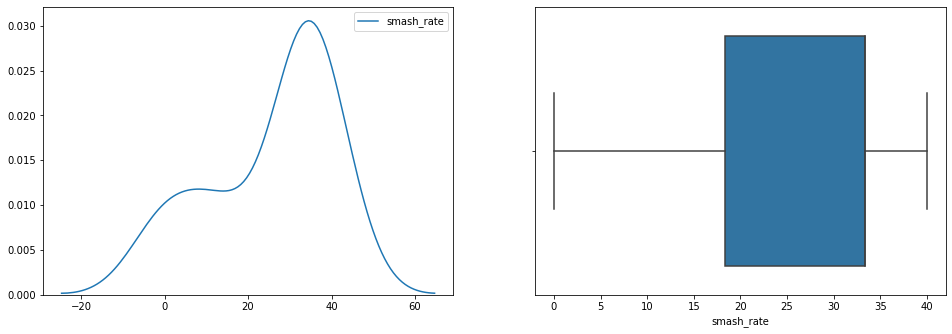

In [555]:
smash_rate("SA Yadav","Sunrisers Hyderabad")

- W Saha

          batsman_runs  ball  boundary count  smash_rate
match_id                                                
22                  11    15             0.0    0.000000
50                  93    55            14.0   25.454545
99                   1     6             0.0    0.000000
138                  8     4             1.0   25.000000
479                 59    47             7.0   14.893617
505                  3     8             0.0    0.000000
552                 12    12             1.0    8.333333
619                 56    40             7.0   17.500000
7900                22    20             3.0   15.000000
7916                 0     2             0.0    0.000000
11342               25    15             5.0   33.333333
 
Average Smash Rate : 12.68


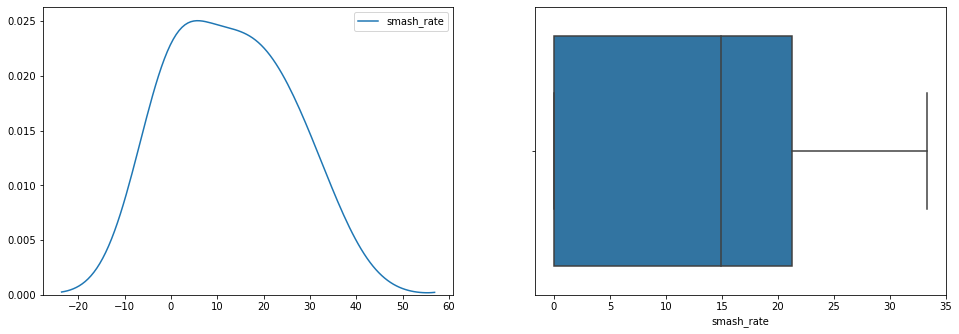

In [557]:
smash_rate("WP Saha","Mumbai Indians")

- Kane Williamson

          batsman_runs  ball  boundary count  smash_rate
match_id                                                
613                  2     5             0.0    0.000000
7900                 6     4             1.0   25.000000
7916                29    21             5.0   23.809524
11342                3     7             0.0    0.000000
 
Average Smash Rate : 12.2


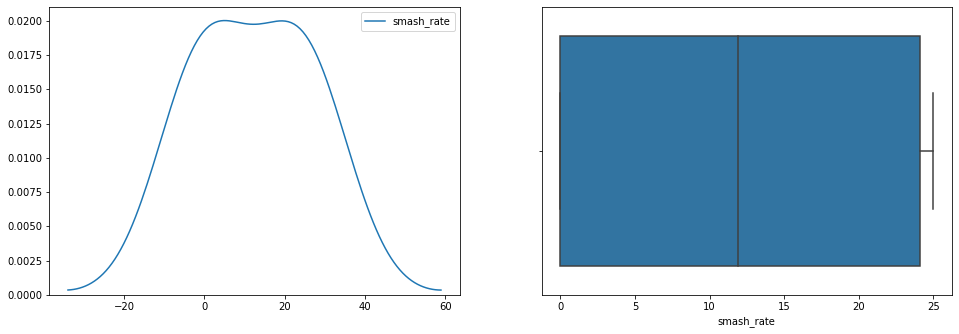

In [559]:
smash_rate("KS Williamson","Mumbai Indians")

- Rohit Sharma

          batsman_runs  ball  boundary count  smash_rate
match_id                                                
10                   4     4             0.0    0.000000
47                  67    45             8.0   17.777778
423                 22    22             2.0    9.090909
444                 20    15             2.0   13.333333
477                  1     5             0.0    0.000000
493                 14     6             3.0   50.000000
541                 24    15             3.0   20.000000
572                  7     2             1.0   50.000000
588                  5     8             0.0    0.000000
613                  5     3             1.0   33.333333
7900                11    10             2.0   20.000000
7916                 2     6             0.0    0.000000
11310               11    14             1.0    7.142857
11342               24    18             5.0   27.777778
 
Average Smash Rate : 17.75


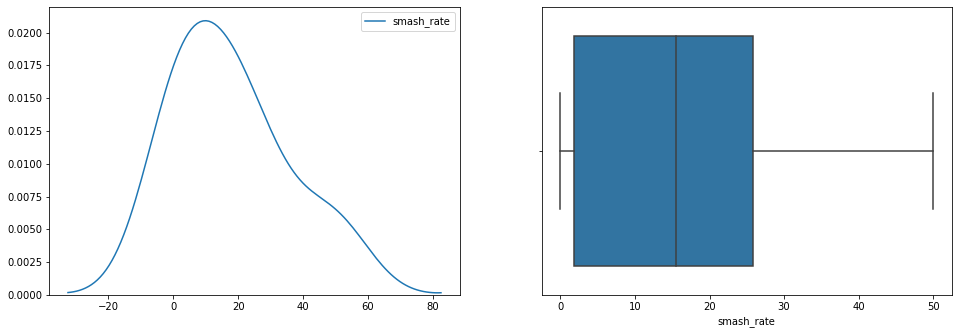

In [613]:
smash_rate("RG Sharma","Sunrisers Hyderabad")

From all the above smash rate that we have calculated of varius players we can predict that anyone of Surya Kumar Yadav , Warner are expected to have higher smash rate in this match.

# Boundary Leaker

In [284]:
def Boundary_Leaker(player_name,opposition_team):
    
    player = matches[(matches["batting_team"] == opposition_team)&(matches["bowler"]==player_name)]
    
    player = player[(player["wide_runs"]==0)&(player["noball_runs"]==0)]
    
    #boundary count
    player_bound = player[(player["batsman_runs"]==4)|(player["batsman_runs"]==6)]
    
    bound_count = pd.DataFrame(player_bound.groupby(["match_id"])["batsman_runs"].count())

    bound_count.columns = ["boundary count"]
    
    # total balls bowled
    total_balls = pd.DataFrame(player.groupby(["match_id"])["ball"].count())
    
    #merging dataframes
    final = pd.merge(total_balls,bound_count,on = "match_id",how = "outer")
    
    final["boundary count"].fillna(0, inplace = True)
    
    BL =  1 / (final["ball"]/final["boundary count"]+1)
    
    BL_player = sum(BL)/len(BL)
    print("Average BL of the bowler:",round(BL_player,2))

- J Bumrah

In [285]:
Boundary_Leaker("JJ Bumrah","Sunrisers Hyderabad")

Average BL of the bowler: 0.11


- Trent Boult

In [561]:
Boundary_Leaker("TA Boult","Sunrisers Hyderabad")

Average BL of the bowler: 0.17


- Rashid Khan

In [562]:
Boundary_Leaker("Rashid Khan","Mumbai Indians")

Average BL of the bowler: 0.08


- Rahul Chahar

In [580]:
Boundary_Leaker("RD Chahar","Sunrisers Hyderabad")

Average BL of the bowler: 0.09


-  Pollard

In [581]:
Boundary_Leaker("KA Pollard","Sunrisers Hyderabad")

Average BL of the bowler: 0.15


- Sandeep Sharma

In [582]:
Boundary_Leaker("Sandeep Sharma","Mumbai Indians")

Average BL of the bowler: 0.14


- K Ahmed

In [583]:
Boundary_Leaker("K Ahmed","Mumbai Indians")

Average BL of the bowler: 0.23


- Krunal Pandya

In [584]:
Boundary_Leaker("KH Pandya","Sunrisers Hyderabad")

Average BL of the bowler: 0.04


From all the above BL score of varius bowlers we can predict that Rashid Khan is expected to have best BL score.

## Total wicket fall in the match

- Overall

In [331]:
wickets = pd.DataFrame(SRH_MI.groupby(['match_id'])["player_dismissed"].count())

wickets.columns = ["wickets"]

print("Wicket fall per match in SRH VS MI matches :")

wickets

Wicket fall per match in SRH VS MI matches :


,wickets
match_id,
10,14
47,10
423,7
444,7
477,12
493,6
541,16
572,11
588,9


In [332]:
(wickets["wickets"]>10).value_counts()

True     9
False    5
Name: wickets, dtype: int64

In [333]:
wickets.describe().T

,count,mean,std,min,25%,50%,75%,max
wickets,14.0,12.142857,4.258153,6.0,9.25,11.5,15.5,20.0


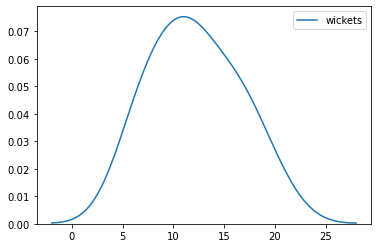

In [334]:
sns.kdeplot(wickets['wickets'])

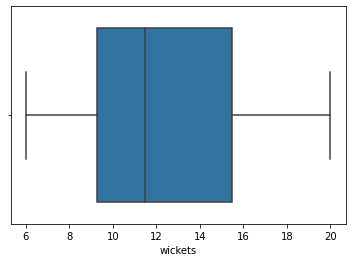

In [335]:
sns.boxplot(wickets['wickets'])

In [336]:
print("Average wicket fall in SRH VS MI matches  :{}".format(round(wickets["wickets"].mean())))

Average wicket fall in SRH VS MI matches  :12


Text(0.5, 1.0, 'Dot Balls count')

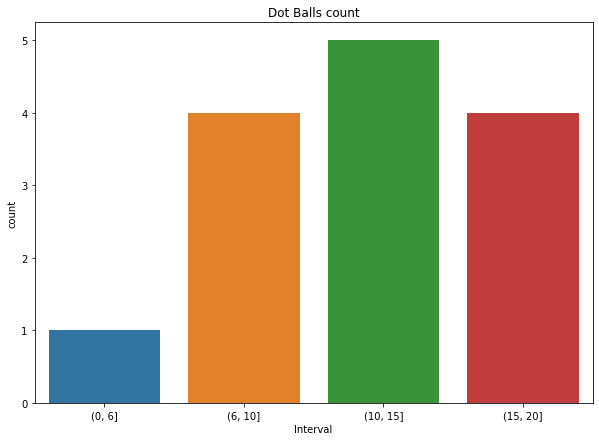

In [337]:
plt.figure(figsize=(10,7))
wickets["Interval"] = pd.cut(wickets["wickets"],[0,6,10,15,20])
sns.countplot(wickets["Interval"])
plt.title("Dot Balls count")

#### Inning-wise

- First Inning

In [338]:
first = SRH_MI[SRH_MI["inning"]==1]

In [339]:
first_innings = pd.DataFrame(first.groupby(["match_id","batting_team"])["player_dismissed"].count())

first_innings.columns =["first innings wickets"]

first_innings

,,first innings wickets
match_id,batting_team,
10,Sunrisers Hyderabad,8
47,Mumbai Indians,7
423,Mumbai Indians,4
444,Sunrisers Hyderabad,3
477,Sunrisers Hyderabad,5
493,Sunrisers Hyderabad,3
541,Mumbai Indians,8
572,Sunrisers Hyderabad,10
588,Mumbai Indians,6


In [340]:
first_innings.describe().T

,count,mean,std,min,25%,50%,75%,max
first innings wickets,14.0,6.214286,2.455091,3.0,4.25,6.5,8.0,10.0


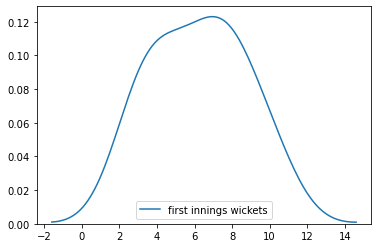

In [341]:
sns.kdeplot(first_innings["first innings wickets"])

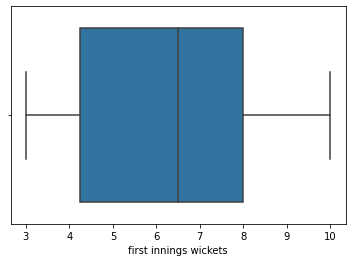

In [342]:
sns.boxplot(first_innings["first innings wickets"])

In [343]:
print("Average wicket fall in SRH VS MI matches in 1st innings :{}".format(round(first_innings["first innings wickets"].mean())))

Average wicket fall in SRH VS MI matches in 1st innings :6


Text(0.5, 1.0, 'Wicket fall count')

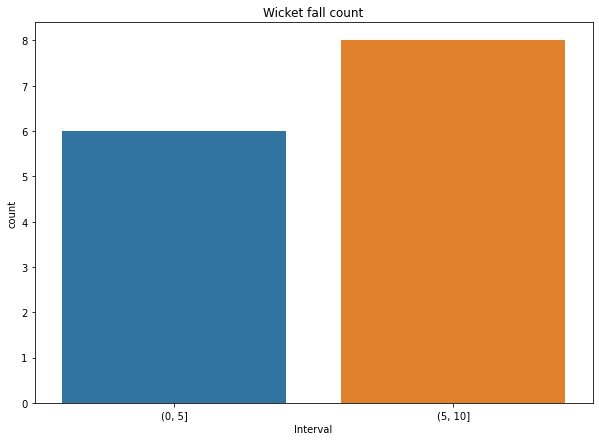

In [344]:
plt.figure(figsize=(10,7))
first_innings["Interval"] = pd.cut(first_innings["first innings wickets"],[0,5,10])
sns.countplot(first_innings["Interval"])
plt.title("Wicket fall count")

- 2nd innings

In [345]:
second = SRH_MI[SRH_MI["inning"]==2]

In [346]:
second_innings = pd.DataFrame(second.groupby(["match_id","batting_team"])["player_dismissed"].count())

second_innings.columns =["second innings wickets"]

second_innings

,,second innings wickets
match_id,batting_team,
10,Mumbai Indians,6
47,Sunrisers Hyderabad,3
423,Sunrisers Hyderabad,3
444,Mumbai Indians,4
477,Mumbai Indians,7
493,Mumbai Indians,3
541,Sunrisers Hyderabad,8
572,Mumbai Indians,1
588,Sunrisers Hyderabad,3


In [347]:
second_innings.describe().T

,count,mean,std,min,25%,50%,75%,max
second innings wickets,14.0,5.928571,3.124698,1.0,3.0,6.0,8.75,10.0


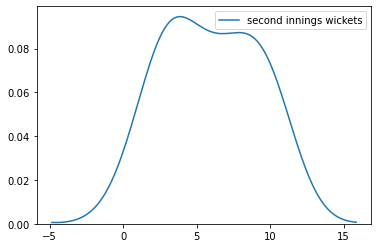

In [348]:
sns.kdeplot(second_innings["second innings wickets"])

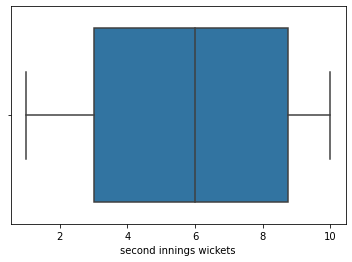

In [349]:
sns.boxplot(second_innings["second innings wickets"])

In [350]:
print("Average wicket fall in SRH VS MI matches in 2nd innings :{}".format(round(second_innings["second innings wickets"].mean())))

Average wicket fall in SRH VS MI matches in 2nd innings :6


Text(0.5, 1.0, 'Wicket fall count')

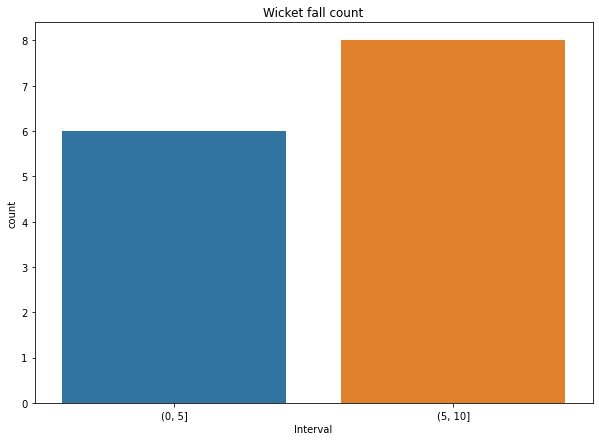

In [351]:
plt.figure(figsize=(10,7))
second_innings["Interval"] = pd.cut(second_innings["second innings wickets"],[0,5,10])
sns.countplot(second_innings["Interval"])
plt.title("Wicket fall count")

From all the above analysis we can predict that total wickets that are expected to fall in this match are 11-15